In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/0f72db9c-d635-4415-9781-68937328aed2___NREC_B.Spot 9188.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/1b8d3e98-43d9-441d-93ef-a359e6e9ddc2___NREC_B.Spot 9052.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/b6d35d21-4812-4e32-ab9a-b6ddda8cbb79___JR_B.Spot 8972.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/e4e7e5a2-5aa1-4378-833d-9142358c7c9b___JR_B.Spot 9092.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/8b50f2db-cbf2-4758-bea6-a011f0cc1497___JR_B.Spot 3235.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/729b55d7-2a99-4861-910d-3b4e2bbce13a___JR_B.Spot 9036.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/4614ed01-e120-4ae9-8f13-028fa8297873___JR_B.Spot 8985.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/b143a281-5395-4a2a-830

# Loading Data to a TensorFlow Dataset

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import os
import shutil

# Define the path to your original dataset
original_dataset_path = "/kaggle/input/plant-village/PlantVillage"

# Define the path to the directory where you want to save the subset
subset_dataset_path = "/input/subset-dataset"

# List of classes you want to keep
classes_to_keep = ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]

# Create the subset directory if it doesn't exist
os.makedirs(subset_dataset_path, exist_ok=True)

# Copy the selected classes to the subset directory
for class_name in classes_to_keep:
    source_dir = os.path.join(original_dataset_path, class_name)
    destination_dir = os.path.join(subset_dataset_path, class_name)
    shutil.copytree(source_dir, destination_dir)

print("Subset dataset created successfully.")


Subset dataset created successfully.


In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/input/subset-dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

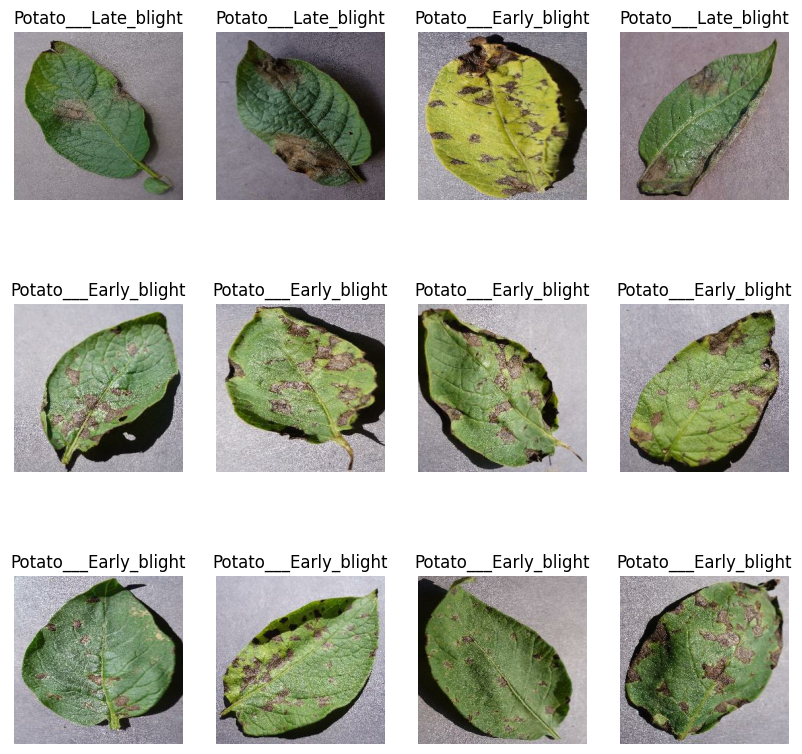

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range (12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")    

In [9]:
# split the data to train, valiadtion and test
# validation set is used while training
# after each epoch, validate against validation set
training_percentage = 0.8
training_size = int(len(dataset)*training_percentage)
train_ds = dataset.take(training_size)
len(train_ds)

54

In [10]:
test_and_validation_ds = dataset.skip(training_size) #skip the used elements for the train_ds
len(test_and_validation_ds)

14

In [11]:
validation_percentage = 0.1
validation_size = int(len(dataset) * validation_percentage)
validation_dataset = test_and_validation_ds.take(validation_size)
len(validation_dataset)

6

In [12]:
test_ds = test_and_validation_ds.skip(validation_size)
len(test_ds)

8

In [13]:
def get_dataset_partition_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(val_ds)

6

In [17]:
len(test_ds)

8

In [18]:
'''
The provided line of code optimizes the `train_ds` dataset for machine learning training. 
It caches elements in memory after the first load 
to reduce data loading times, 
shuffles the data randomly to prevent order-based learning, 
and prefetches batches for more efficient training. 
These steps collectively enhance the training process by minimizing data loading bottlenecks, 
promoting randomness in the data order, and allowing concurrent data preprocessing, 
ultimately leading to improved training performance and efficiency.
'''
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocessing

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Building the Model

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [22]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 23s 76ms/step - loss: 0.8669 - accuracy: 0.5272 - val_loss: 0.6642 - val_accuracy: 0.6944
Epoch 2/50
54/54 [==============================] - 4s 73ms/step - loss: 0.5988 - accuracy: 0.7124 - val_loss: 0.4458 - val_accuracy: 0.8345
Epoch 3/50
54/54 [==============================] - 4s 72ms/step - loss: 0.4405 - accuracy: 0.8148 - val_loss: 0.4431 - val_accuracy: 0.8073
Epoch 4/50
54/54 [==============================] - 4s 72ms/step - loss: 0.4030 - accuracy: 0.8310 - val_loss: 0.3190 - val_accuracy: 0.8709
Epoch 5/50
54/54 [==============================] - 4s 73ms/step - loss: 0.2956 - accuracy: 0.8802 - val_loss: 0.3617 - val_accuracy: 0.8455
Epoch 6/50
54/54 [==============================] - 4s 75ms/step - loss: 0.2426 - accuracy: 0.9068 - val_loss: 0.2195 - val_accuracy: 0.9051
Epoch 7/50
54/54 [==============================] - 4s 73ms/step - loss: 0.1915 - accuracy: 0.9242 - val_loss: 0.1384 - val_accuracy: 0.9410
Epoch 8/50
5

In [25]:
scores = model.evaluate(test_ds)

54/54 [==============================] - 1s 22ms/step - loss: 4.3315e-06 - accuracy: 1.0000


In [26]:
scores

[4.331500804255484e-06, 1.0]

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

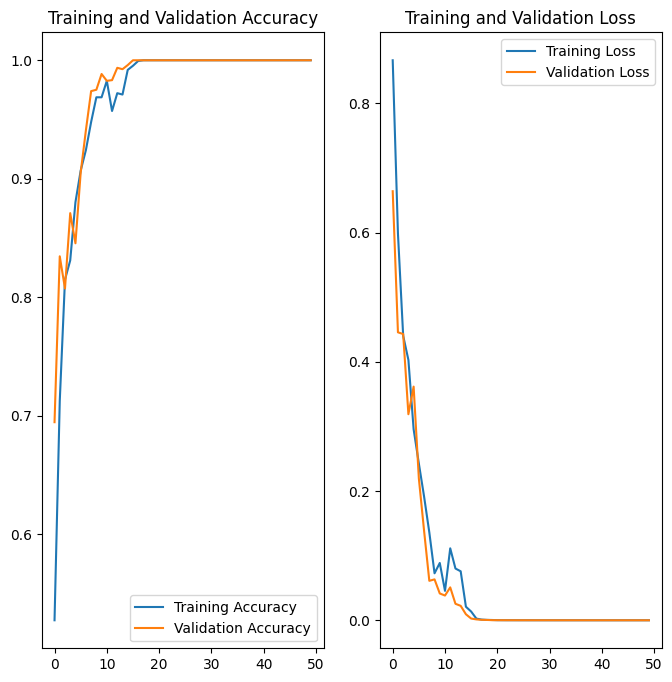

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 190ms/step
predicted label: Potato___Late_blight


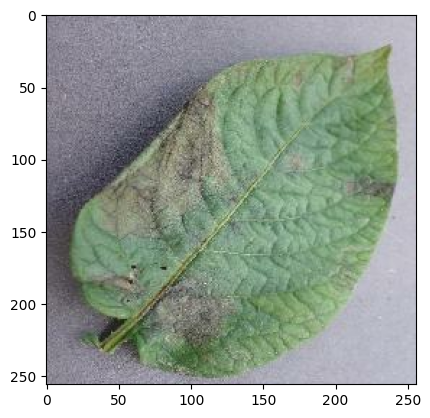

In [29]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


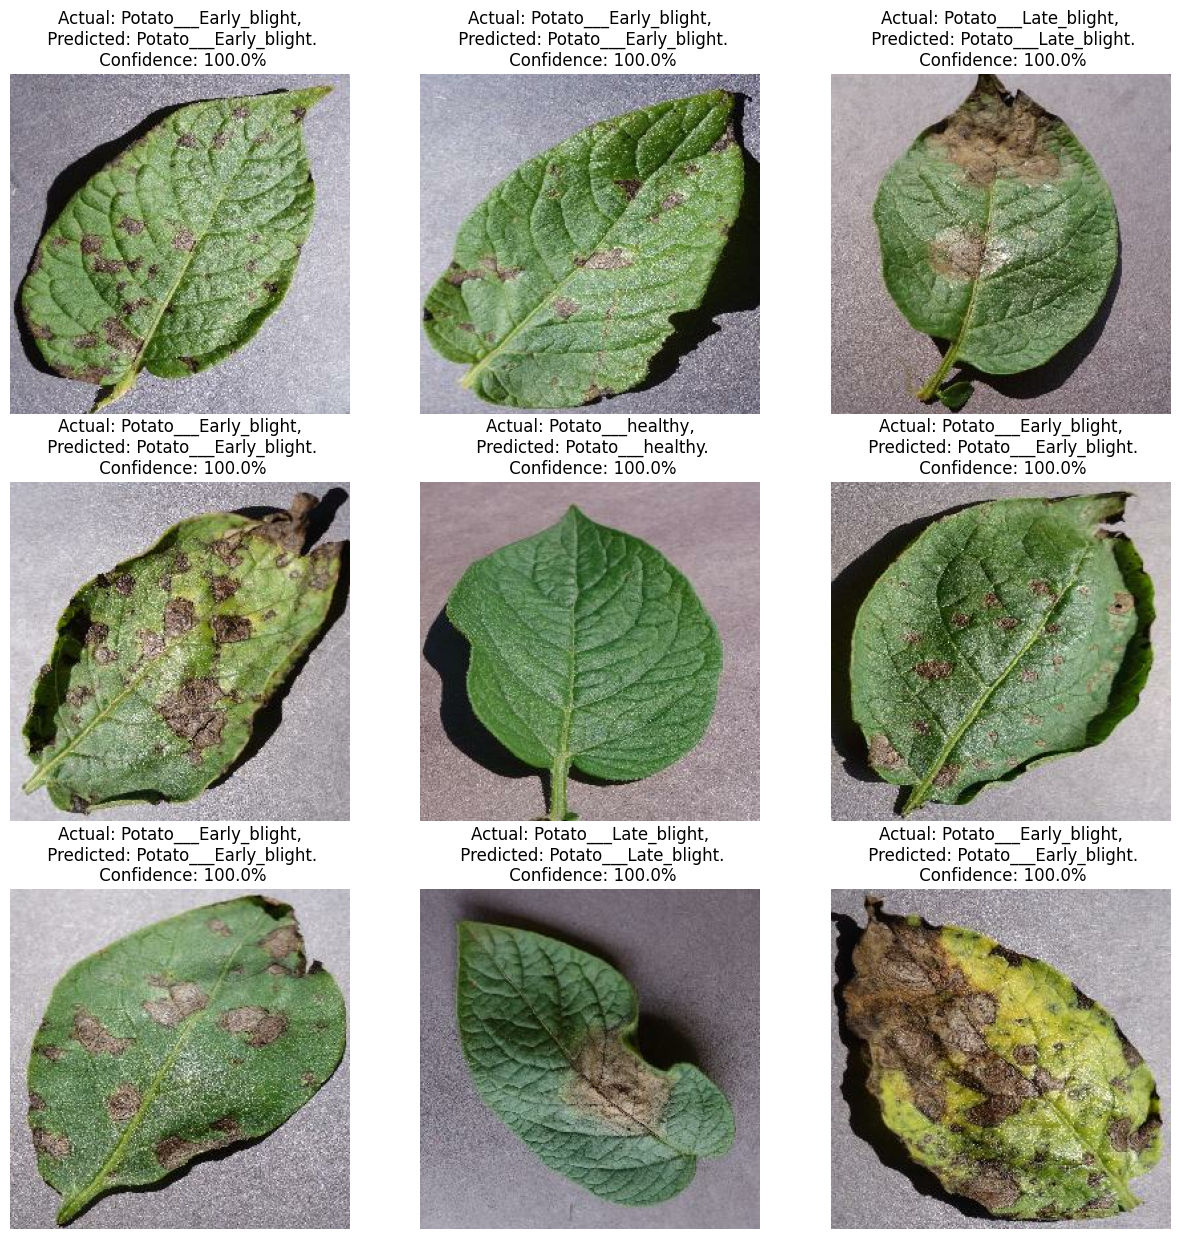

In [31]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [35]:
model_version=1
model.save(f'/kaggle/working/{model_version}')

In [36]:
model.save("/kaggle/working/potatoes.h5")